In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, mean_squared_error, roc_curve, auc
from sklearn.feature_selection import SelectFromModel, GenericUnivariateSelect
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression, HuberRegressor, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier

In [2]:
df_feats = pd.read_csv('df_feats.csv')
df_targets = pd.read_csv('df_targets.csv')

### Helper functions

In [3]:
def _color_red_or_green(val):
    color = 'green' if val > 0.75 else ('orange' if val > 0.65 else ('red' if val < 0.65 else 'black'))
    return 'color: %s' % color

In [4]:
def coefs_to_df(X, model, features_selected, scaler, dict_name, K_all, fs_method=None):
    """
    This function extracts the feature coefficients of a model and saves it in to a dataframe
    """ 
    
    tree_models = ['RandomForestRegressor', 'RandomForestClassifier', 'XGBClassifier']
    
    
    if model.__class__.__name__ in tree_models:
        
        coefs = model.feature_importances_
        
    else:
        
        coefs = model.coef_
     

    if fs_method == 'PCA':
        
        pca_coefs = features_selected.components_.T * coefs
        
        all_coefs = pca_coefs.sum(axis=1)

    else:
       
        coefs_vals = coefs.flatten().tolist()
    
        # getting indexes of remaining features' coefficients
        coefs_inds = [i for i, element in enumerate(features_selected.get_support()) if element == True]

        all_coefs = [coefs_vals[coefs_inds.index(i)] if i in coefs_inds else 0 for i in range(len(X.columns))]
        

    all_coefs_df = pd.DataFrame([all_coefs], columns=X.columns)
    all_coefs_df['Model'] = model.__class__.__name__
    all_coefs_df['Scaler'] = scaler.__class__.__name__
    all_coefs_df['Feat Selection'] = dict_name
    all_coefs_df['Type'] = 'All_data'
    all_coefs_df['Num of Features'] = K_all
    
    all_coefs_df.set_index(['Model', 'Scaler', 'Feat Selection', 'Type', 'Num of Features'], inplace=True)
    
    return all_coefs_df

In [5]:
def get_classification_metrics(clf, X, y):

    clf.fit(X, y)
    y_pred = clf.predict(X)

    accuracy_all = accuracy_score(y, y_pred)
    f1_all = f1_score(y, y_pred, average='weighted')
    sensitivity_all = recall_score(y, y_pred, average='weighted')
    specificity_all = recall_score(y, y_pred, labels=[0], average='weighted')
    fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=1)
    auc_all = auc(fpr, tpr)

    return [accuracy_all, f1_all, sensitivity_all, specificity_all, auc_all]

## Classifiers 

target - cesdclinmA (Depression - yes/no)

In [6]:
start_total_runtime = time.time()

# Dependent and independent variables

X = df_feats.drop(columns = ['study_id'])
y = df_targets['cesdclinmA'].astype(int)

# Models
models = [LogisticRegression(max_iter=3000, solver='liblinear'),
         RandomForestClassifier(max_depth=5, min_samples_split=4, n_estimators = 200, min_samples_leaf=3),
         XGBClassifier(use_label_encoder=False, eval_metric='error', eta=1, max_depth=4)]

# Scalers
scalers = [StandardScaler(), RobustScaler()]

# Feature selections methods
selectors = [PCA(), GenericUnivariateSelect(mode='fpr', param=0.5), Lasso(alpha=0.15, max_iter=5000, tol=0.2)]

# list of results per model
final_results = []

# Dataframe saving each model's coefficients
coefs_df_clfs = pd.DataFrame()

# Cross-Validation object
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

max_val_accuracy = 0

# Testing each of the models
for model in models:
    
    # Testing each of the scalers
    for scaler in scalers:
                
            all_scores = {'PCA': {'Accuracy_All_X': [], 'F1_All_X': [], 'Sensitivity_All_X': [], 
                          'Specificity_All_X': [], 'AUC_All_X': [], 'K_All_X': [],
                          'Train_Accuracy_CV': [], 'Val_Accuracy_CV': [], 'Train_F1_CV': [], 'Val_F1_CV': [], 
                          'Val_Sensitivity_CV': [], 'Val_Specificity_CV': [], 'Val_AUC_CV': [], 'K': []}, 
                          
                         'FPR': {'Accuracy_All_X': [], 'F1_All_X': [], 'Sensitivity_All_X': [], 
                          'Specificity_All_X': [], 'AUC_All_X': [], 'K_All_X': [],
                         'Train_Accuracy_CV': [], 'Val_Accuracy_CV': [], 'Train_F1_CV': [], 'Val_F1_CV': [], 
                          'Val_Sensitivity_CV': [], 'Val_Specificity_CV': [], 'Val_AUC_CV': [], 'K': []}, 
                          
                        'Lasso': {'Accuracy_All_X': [], 'F1_All_X': [], 'Sensitivity_All_X': [], 
                        'Specificity_All_X': [], 'AUC_All_X': [], 'K_All_X': [],
                        'Train_Accuracy_CV': [], 'Val_Accuracy_CV': [], 'Train_F1_CV': [], 'Val_F1_CV': [], 
                        'Val_Sensitivity_CV': [], 'Val_Specificity_CV': [], 'Val_AUC_CV': [], 'K': []}}
                
            # cross-validating
            
            for ind, (train_index, val_index) in enumerate(skf.split(X, y)):
                
                X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                
                # Normalizing
                
                scaler.fit(X_train)
                X_train = scaler.transform(X_train)
                X_val = scaler.transform(X_val)
                
                # Testing each of the feature selection methods
                
                for feat_selector in selectors:
                    
                    # Creating new X-sets for each iteration
                    X_train_fresh = X_train
                    X_val_fresh = X_val
                    
                    dict_name = feat_selector.__class__.__name__
                    
                    if dict_name == 'PCA':
            
                        fs = feat_selector.fit(X_train_fresh)
                        array = np.cumsum(fs.explained_variance_ratio_)
                        
                        # Selecting number of principal components
                        
                        K = np.argmax(array > 0.8)
                        fs = PCA(n_components=K).fit(X_train_fresh)
                        
                        if ind == 0:
                            
                            # Calculating metrics on all X Data
                            
                            X = df_feats.drop(columns = ['study_id'])
                            y = df_targets['cesdclinmA'].astype(int)
                            scaler.fit(X)
                            X = pd.DataFrame(scaler.transform(X), columns=X.columns)
                            
                            pca = PCA()
                            fs_all_pca = pca.fit(X)
                            array_all = np.cumsum(fs_all_pca.explained_variance_ratio_)
                            
                            # Selecting number of principal components
                            
                            K_all = np.argmax(array_all > 0.9)

                            fs_all_pca = PCA(n_components=K_all).fit(X)
                            
                            X_all_pca = fs_all_pca.transform(X)
                            
                            clf_all_pca = model
                            
                            metrics_all = get_classification_metrics(clf_all_pca, X_all_pca, y)
                            
                            # Getting coefficients of all features
                            
                            all_coefs_df_pca = coefs_to_df(X, clf_all_pca, fs_all_pca, scaler, dict_name, K_all, 'PCA')
                            
                            coefs_df_clfs = pd.concat([coefs_df_clfs, all_coefs_df_pca], axis=0)
        

                    elif dict_name == 'Lasso':               

                        fs = SelectFromModel(feat_selector)
                        fs.fit(X_train_fresh, y_train)
                        K = sum(fs.get_support())
                        
                        if ind == 0:
                            
                            # Calculating metrics on all X Data
                           
                            fs_all_lasso = SelectFromModel(feat_selector)
                            fs_all_lasso.fit(X, y)
                            X_all_lasso = fs_all_lasso.transform(X)
                            
                            clf_all_lasso = model
                            
                            metrics_all = get_classification_metrics(clf_all_lasso, X_all_lasso, y)
                            
                            K_all = sum(fs_all_lasso.get_support())
                            
                            
                            
                            # Getting coefficients of all features
                            
                            all_coefs_df_lasso = coefs_to_df(X, clf_all_lasso, fs_all_lasso, scaler, dict_name, K_all)
                            
                            coefs_df_clfs = pd.concat([coefs_df_clfs, all_coefs_df_lasso], axis=0)
                        
                    else:
                        
                        dict_name = 'FPR'
                        fs = feat_selector.fit(X_train_fresh, y_train)
                        
                        K = sum(fs.get_support())
                        
                        if ind == 0:
                            
                            # Calculating metrics on all X Data
                            
                            fs_all_fpr = feat_selector.fit(X, y)
                            X_all_fpr = fs_all_fpr.transform(X)
                            
                            clf_all_fpr = model
                            
                            metrics_all = get_classification_metrics(clf_all_fpr, X_all_fpr, y)
                            
                            K_all = sum(fs_all_fpr.get_support())
                            
                            # Getting coefficients of all features
                            
                            all_coefs_df_fpr = coefs_to_df(X, clf_all_fpr, fs_all_fpr, scaler, dict_name, K_all)
                            
                            coefs_df_clfs = pd.concat([coefs_df_clfs, all_coefs_df_fpr], axis=0)
                                        
                    X_train_fresh = fs.transform(X_train_fresh)
                    X_val_fresh = fs.transform(X_val_fresh)
                    
                    # Training, predicting and evaluating each model
                    
                    clf = model
          
                    clf.fit(X_train_fresh, y_train)
                    y_pred_train = clf.predict(X_train_fresh)
                    y_pred_val = clf.predict(X_val_fresh)
                    
                    # appending metrics of all data to all_scores dictionary
                    if ind == 0:
                        for i, key in enumerate(all_scores[dict_name]):
                            if i == 5:
                                break
                            all_scores[dict_name][key].append(metrics_all[i])
                        all_scores[dict_name]['K_All_X'].append(K_all)
                    
                    # appending metrics of specific fold
                    all_scores[dict_name]['Train_Accuracy_CV'].append(accuracy_score(y_train, y_pred_train))
                    all_scores[dict_name]['Train_F1_CV'].append(f1_score(y_train, y_pred_train, average='weighted'))
                    
                    all_scores[dict_name]['Val_Accuracy_CV'].append(accuracy_score(y_val, y_pred_val))
                    all_scores[dict_name]['Val_F1_CV'].append(f1_score(y_val, y_pred_val, average='weighted'))
                    all_scores[dict_name]['Val_Sensitivity_CV'].append(recall_score(y_val, y_pred_val, average='weighted'))
                    all_scores[dict_name]['Val_Specificity_CV'].append(recall_score(y_val, y_pred_val, labels = [0], average='weighted'))
                    fpr, tpr, thresholds = roc_curve(y_val, y_pred_val, pos_label=1)
                    all_scores[dict_name]['Val_AUC_CV'].append(auc(fpr, tpr))

                    all_scores[dict_name]['K'].append(K)
                    

                            
                        
            # Averaging CV results of splits
            for dct, v in all_scores.items():
                for metric, score in v.items():
                        v[metric] = np.mean(score)
            
            
            dicts_keys = ['PCA', 'FPR', 'Lasso']
            
            for dct in dicts_keys:
                final_results.append({'Model': clf.__class__.__name__, 'scaler': scaler.__class__.__name__, 
                                      'Feat Selection': dct,
                                      'Type': 'CV',
                                      'Num of Features': round(all_scores[dct]['K']),
                                      'Train_Accuracy_CV': all_scores[dct]['Train_Accuracy_CV'], 
                                      'Val_Accuracy_CV': all_scores[dct]['Val_Accuracy_CV'], 
                                      'Train_F1_CV': all_scores[dct]['Train_F1_CV'], 
                                      'Val_F1_CV': all_scores[dct]['Val_F1_CV'], 
                                      'Val_Sensitivity_CV': all_scores[dct]['Val_Sensitivity_CV'], 
                                      'Val_Specificity_CV': all_scores[dct]['Val_Specificity_CV'], 
                                      'Val_AUC_CV': all_scores[dct]['Val_AUC_CV']})
                final_results.append({'Model': clf.__class__.__name__, 'scaler': scaler.__class__.__name__, 
                                      'Feat Selection': dct,
                                      'Type': 'All_data',
                                      'Num of Features': int(all_scores[dct]['K_All_X']),
                                      'Accuracy_All_X': all_scores[dct]['Accuracy_All_X'],
                                      'F1_All_X': all_scores[dct]['F1_All_X'],
                                      'Sensitivity_All_X': all_scores[dct]['Sensitivity_All_X'],
                                      'Specificity_All_X': all_scores[dct]['Specificity_All_X'],
                                      'AUC_All_X': all_scores[dct]['AUC_All_X']})  
                
# normalizing coefficients
coefs_df_clfs = coefs_df_clfs.abs()
coefs_df_clfs = (coefs_df_clfs.T / coefs_df_clfs.T.sum()).T
                    
final_results_df = pd.DataFrame(final_results).set_index(['Model', 'scaler', 'Feat Selection', 'Type'])  

end_total_runtime = time.time()

print(f'Total runtime: {round(end_total_runtime - start_total_runtime,5)} seconds')

final_results_df.style.applymap(_color_red_or_green)

Total runtime: 15.39007 seconds


In [7]:
final_results_df.sort_values(by=['Val_Accuracy_CV'], ascending=False)[0:8].style.applymap(_color_red_or_green)

### Top Features vs models Heatmap:

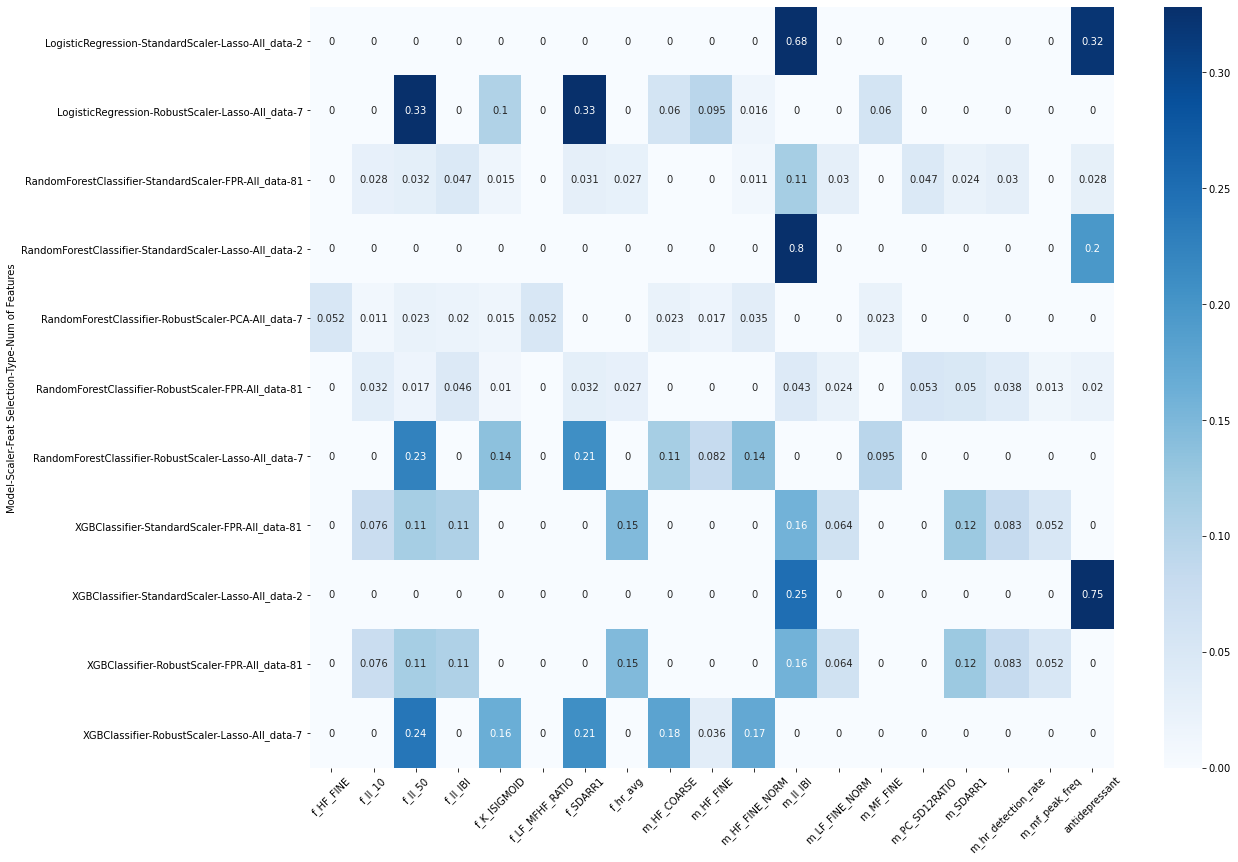

In [8]:
fig, ax = plt.subplots(figsize=(18, 14))

top_coefs = coefs_df_clfs.loc[coefs_df_clfs.max(axis=1) > 0.05, coefs_df_clfs.max(axis=0) > 0.05]

top_coefs[(top_coefs < 0.01) & (top_coefs > 0) | (top_coefs > -0.01) & (top_coefs < 0)] = 0

sns.heatmap(top_coefs, robust=True, annot=True, cmap="Blues")
plt.savefig('heatmap_clf.png',bbox_inches="tight")
ax.set_xticklabels(top_coefs.columns, rotation=45)
plt.show()

#### Exporting to csv:

In [9]:
final_results_df.to_csv('Baseline_Classifiers_Results.csv')
coefs_df_clfs.to_csv('Baseline_Classifiers_Coefficients.csv')

## Regressors

In [10]:
def _color_red_or_green_reg(val):
    color = 'green' if val > 0.75 else ('orange' if val > 0 else ('red' if val < 0 else 'black'))
    return 'color: %s' % color

In [11]:
def get_regression_metrics(regressor, X, y):

    regressor.fit(X, y)

    r2_all = regressor.score(X, y)
    adj_r2_all = 1 - (1 - r2_all) * (len(y) - 1) / (len(y) - X.shape[1] - 1)

    y_pred_all = regressor.predict(X)
    
    rmse_all = np.sqrt(mean_squared_error(y, y_pred_all))
    
    return [r2_all, adj_r2_all, rmse_all]

#### Filtering and normalizing numerical targets so they would be on same scale:

Targets which will no be predicte in the below models: 

cesdsevmA - severity score, cesdclinmA - binary, psaavmA - avg score per question

In [12]:
def build_regressors(X, targets):
    """
    Building baseline regressors and saving their coefficients.
    Function can take a list of targets.
    Results and coefficients per model are exported to csv files.
    """

    reg_models = [LinearRegression(),HuberRegressor(alpha=0.01, max_iter=50000), RandomForestRegressor(n_estimators=300, 
                  max_depth=5, min_samples_leaf=2, min_samples_split=4, random_state=0)]

    # Scalers
    scalers = [StandardScaler(), RobustScaler()]

    # Feature selections methods
    reg_selectors = [PCA(), GenericUnivariateSelect(mode='fdr', param=0.5), Lasso(alpha=0.01, max_iter=50000, tol=0.2)]

    # list of results per model
    final_results_reg = []

    # Dataframe saving each model's coefficients
    coefs_df_reg = pd.DataFrame()

    # Cross-Validation object
    kf = KFold(n_splits=10, random_state=0, shuffle=True)

    # Testing each of the models
    with np.errstate(divide='ignore', invalid='ignore'):
        for model in reg_models:

            # Testing each dependent variable
            for target in targets:

                if target == 'DERStotmA':
                    
                    # dropping study ids which have missing DERS scores
                    X = df_feats[(df_feats['study_id'] != 1792) & (df_feats['study_id'] != 1812)]

                X = df_feats.drop(columns=['study_id'])
                y = df_targets[target]

                # Testing each of the scalers
                for scaler in scalers:
                    
                    scores = {'R2(All_X)': [], 'Adj_R2(All_X)': [], 'rmse(All_X)': [], 'K_All_X': [],
                             'Train_R2_CV': [], 'Adj_Train_R2_CV': [], 'Val_R2_CV': [], 'Adj_Val_R2_CV': [],
                             'Train_rmse_CV': [], 'Val_rmse_CV': [], 'K': [], 'target': ''}
                    
                    all_scores = {'PCA': scores, 'FDR': scores, 'Lasso': scores}

                    # cross-validation
                    
                    for ind, (train_index, val_index) in enumerate(kf.split(X, y)):
                        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

                        # Normalizing
                        
                        scaler.fit(X_train)
                        X_train = scaler.transform(X_train)
                        X_val = scaler.transform(X_val)

                        # Testing each of the feature selection methods
                        
                        for feat_selector in reg_selectors:

                            # Creating new X-sets for each iteration
                            
                            X_train_fresh = X_train
                            X_val_fresh = X_val

                            dict_name = feat_selector.__class__.__name__

                            if dict_name == 'PCA':

                                fs = feat_selector.fit(X_train_fresh)
                                array = np.cumsum(fs.explained_variance_ratio_)

                                # Selecting number of principal components
                                
                                K = np.argmax(array > 0.8)
                                fs = PCA(n_components=K).fit(X_train_fresh)

                                if ind == 0:
                                    
                                    # Calculating metrics on all X Data
                                    
                                    fs_all_pca = PCA().fit(X)
                                    array_all = np.cumsum(fs_all_pca.explained_variance_ratio_)

                                    # Selecting number of principal components
                                    
                                    K_all = np.argmax(array_all > 0.85)
                                    fs_all_pca = PCA(n_components=K_all).fit(X)

                                    X_all_pca = fs_all_pca.transform(X)

                                    reg = model
                                
                                    reg_metrics_all = get_regression_metrics(reg, X_all_pca, y)
                                    
                                    # Getting coefficients of all features

                                    all_coefs_df_pca = coefs_to_df(X, reg, fs_all_pca, scaler, dict_name, K_all, 'PCA')

                                    coefs_df_reg = pd.concat([coefs_df_reg, all_coefs_df_pca], axis=0)

                            elif dict_name == 'Lasso':

                                fs = SelectFromModel(feat_selector)
                                fs.fit(X_train_fresh, y_train)
                                K = sum(fs.get_support())

                                if ind == 0:
                                    
                                    # Calculating metrics on all X Data
                                    
                                    fs_all_lasso = SelectFromModel(feat_selector)
                                    fs_all_lasso.fit(X, y)
                                    X_all_lasso = fs_all_lasso.transform(X)

                                    reg = model
                                    
                                    reg_metrics_all = get_regression_metrics(reg, X_all_lasso, y)
                                    
                                    K_all = sum(fs_all_lasso.get_support())

                                    # Getting coefficients of all features

                                    all_coefs_df_lasso = coefs_to_df(X, reg, fs_all_lasso, scaler, dict_name, K_all)

                                    coefs_df_reg = pd.concat([coefs_df_reg, all_coefs_df_lasso], axis=0)

                            else:

                                dict_name = 'FDR'

                                fs = feat_selector.fit(X_train_fresh, y_train)
                                K = sum(fs.get_support())

                                if ind == 0:
                                    
                                    # Calculating metrics on all X Data
                                    
                                    fs_all_fdr = feat_selector.fit(X, y)
                                    X_all_fdr = fs_all_fdr.transform(X)

                                    reg = model
                                    
                                    reg_metrics_all = get_regression_metrics(reg, X_all_fdr, y)
                                    
                                    K_all = sum(fs_all_fdr.get_support())

                                    # Getting coefficients of all features

                                    all_coefs_df_fdr = coefs_to_df(X, reg, fs_all_fdr, scaler, dict_name, K_all)

                                    coefs_df_reg = pd.concat([coefs_df_reg, all_coefs_df_fdr], axis=0)
                                    
                            
                            # appending metrics of all data to all_scores dictionary
                            if ind == 0:
                                for i, key in enumerate(all_scores[dict_name]):
                                    if i == 3:
                                        break
                                    all_scores[dict_name][key].append(reg_metrics_all[i])
                            all_scores[dict_name]['K_All_X'].append(K_all)

                            X_train_fresh = fs.transform(X_train_fresh)
                            X_val_fresh = fs.transform(X_val_fresh)

                            # Training, predicting and evaluating each model

                            reg = model
                            reg.fit(X_train_fresh, y_train)

                            train_r2 = reg.score(X_train_fresh, y_train)
                            adj_train_r2 = 1 - (1 - train_r2) * (len(y_train) - 1) / (
                                        len(y_train) - X_train_fresh.shape[1] - 1)
                            val_r2 = reg.score(X_val_fresh, y_val)
                            adj_val_r2 = 1 - (1 - val_r2) * (len(y_val) - 1) / (len(y_val) - X_val_fresh.shape[1] - 1)

                            y_pred_train = reg.predict(X_train_fresh)
                            y_pred_val = reg.predict(X_val_fresh)

                            train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
                            val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))

                            # appending metrics of all data to all_scores dictionary
                            if ind == 0:
                                for i, key in enumerate(all_scores[dict_name]):
                                    if i == 3:
                                        break
                                    all_scores[dict_name][key].append(reg_metrics_all[i])
                            all_scores[dict_name]['K_All_X'].append(K_all)

                            # appending metrics of specific fold
                            all_scores[dict_name]['Train_R2_CV'].append(train_r2)
                            all_scores[dict_name]['Adj_Train_R2_CV'].append(adj_train_r2)
                            all_scores[dict_name]['Val_R2_CV'].append(val_r2)
                            all_scores[dict_name]['Adj_Val_R2_CV'].append(adj_val_r2)
                            all_scores[dict_name]['Train_rmse_CV'].append(train_rmse)
                            all_scores[dict_name]['Val_rmse_CV'].append(val_rmse)
                            all_scores[dict_name]['K'].append(K)
                            all_scores[dict_name]['target'] = target

                    # Averaging the scores of each fold
                    
                    for dct, v in all_scores.items():
                        for metric, score in v.items():
                            if metric != 'target':
                                v[metric] = np.mean(score)

                    dicts_keys = ['PCA', 'FDR', 'Lasso']

                    # Saving results and adding to dataframe
                    for dct in dicts_keys:
                        final_results_reg.append({'Model': reg.__class__.__name__,
                                                  'scaler': scaler.__class__.__name__,
                                                  'Feat Selection': dct,
                                                  'Target': all_scores[dct]['target'],
                                                  'Type': 'CV',
                                                  'Num of Features': round(all_scores[dct]['K']),
                                                  'Train_R2_CV': all_scores[dct]['Train_R2_CV'],
                                                  'Adj_Train_R2_CV': all_scores[dct]['Adj_Train_R2_CV'],
                                                  'Val_R2_CV': all_scores[dct]['Val_R2_CV'],
                                                  'Adj_Val_R2_CV': all_scores[dct]['Adj_Val_R2_CV'],
                                                  'Train_RMSE_CV': all_scores[dct]['Train_rmse_CV'],
                                                  'Val_RMSE_CV': all_scores[dct]['Val_rmse_CV']})
                        final_results_reg.append({'Model': reg.__class__.__name__,
                                                  'scaler': scaler.__class__.__name__,
                                                  'Feat Selection': dct,
                                                  'Target': all_scores[dct]['target'],
                                                  'Type': 'All_data',
                                                  'Num of Features': round(all_scores[dct]['K']),
                                                  'R2(All_X)': all_scores[dct]['R2(All_X)'],
                                                  'Adj_R2(All_X)': all_scores[dct]['Adj_R2(All_X)'],
                                                  'rmse(All_X)': all_scores[dct]['rmse(All_X)']})

    final_results_reg_df = pd.DataFrame(final_results_reg).set_index(['Model', 'Target', 'scaler', 'Feat Selection'])

    return final_results_reg_df, coefs_df_reg


#### Filtering and normalizing numerical targets so they would be on same scale:

Targets which will no be predicte in the below models: 

cesdsevmA - severity score, cesdclinmA - binary, psaavmA - avg score per question

In [13]:
all_targets = ["DERSclrmA", "DERStotmA", "DERSstgmA", "DERSawmA", "DERSimpmA", "DERSgmA", 
               "DERSnamA", "psaavmA", "psatotmA", "cesdtotmA", "cesdclinmA", "cesdsevmA"]

In [14]:
numeric_targets = set(all_targets) ^ {'cesdsevmA', 'cesdclinmA', 'psaavmA'}

In [15]:
min_max_scaler = MinMaxScaler()

for target in numeric_targets:
    tmp_arr = np.array(df_targets[target]).reshape(-1,1)
    min_max_scaler.fit(tmp_arr)
    df_targets[target] = min_max_scaler.transform(tmp_arr)

### Predicting primary targets:

Primary numeric targets (1 from each of the 3 questionnaires) all have 'totmA' suffix

DERStotmA - score for difficulties in emotion regulation scale

cesdtotmA - score for depression

psatotmA - score for anxiety

In [16]:
primary_numeric_targets = [x for x in numeric_targets if x.endswith('totmA')]

start_total_runtime = time.time()

final_results_reg_df, coefs_df_reg_primary = build_regressors(df_feats, primary_numeric_targets)
 
end_total_runtime = time.time()

print(f'Total runtime: {round(end_total_runtime - start_total_runtime,5)} seconds\n')
print('psatotmA = Anxiety \nDERStotmA = Difficulties in emotion regulation \ncesdtotmA = Depression')

final_results_reg_df#.style.applymap(_color_red_or_green_reg)

C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [157 159 168 173] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [157 159 168 173] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [157 163] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [157 163] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [147 15

Total runtime: 180.80184 seconds

psatotmA = Anxiety 
DERStotmA = Difficulties in emotion regulation 
cesdtotmA = Depression


Type  \
Model                 Target    scaler         Feat Selection             
LinearRegression      cesdtotmA StandardScaler PCA                   CV   
                                               PCA             All_data   
                                               FDR                   CV   
                                               FDR             All_data   
                                               Lasso                 CV   
...                                                                 ...   
RandomForestRegressor DERStotmA RobustScaler   PCA             All_data   
                                               FDR                   CV   
                                               FDR             All_data   
                                               Lasso                 CV   
                                               Lasso           All_data   

                                                               Num of Features  \
Model                 Target    scaler         Feat Selection                    
LinearRegression      cesdtotmA StandardScaler PCA                          59   
                                               PCA                          59   
                                               FDR                          59   
                                               FDR                          59   
                                               Lasso                        59   
...                                                                        ...   
RandomForestRegressor DERStotmA RobustScaler   PCA                          63   
                                               FDR                          63   
                                               FDR                          63   
                                               Lasso                        63   
                                               Lasso                        63   

                                                               Train_R2_CV  \
Model                 Target    scaler         Feat Selection                
LinearRegression      cesdtotmA StandardScaler PCA                0.765861   
                                               PCA                     NaN   
                                               FDR                0.765861   
                                               FDR                     NaN   
                                               Lasso              0.765861   
...                                                                    ...   
RandomForestRegressor DERStotmA RobustScaler   PCA                     NaN   
                                               FDR                0.768303   
                                               FDR                     NaN   
                                               Lasso              0.768303   
                                               Lasso                   NaN   

                                                               Adj_Train_R2_CV  \
Model                 Target    scaler         Feat Selection                    
LinearRegression      cesdtotmA StandardScaler PCA                    0.658193   
                                               PCA                         NaN   
                                               FDR                    0.658193   
                                               FDR                         NaN   
                                               Lasso                  0.658193   
...                                                                        ...   
RandomForestRegressor DERStotmA RobustScaler   PCA                         NaN   
                                               FDR                    0.971103   
                                               FDR                         NaN   
                                               Lasso                  0.971103   
                         

#### Saving to CSV

In [17]:
final_results_reg_df.to_csv('Baseline_Regressors_Results(Primary_Targets).csv')
coefs_df_reg_primary.to_csv('Baseline_Regressors_Coefficients(Primary_Targets).csv')

### Predicting secondary targets:

In [18]:
secondary_numeric_targets = numeric_targets ^ set(primary_numeric_targets)

start_total_runtime = time.time()

final_results_reg_sec_df, coefs_df_reg_sec= build_regressors(df_feats, secondary_numeric_targets)
 
end_total_runtime = time.time()

print(f'Total runtime: {round(end_total_runtime - start_total_runtime,5)} seconds\n')

final_results_reg_sec_df#.style.applymap(_color_red_or_green_reg)

C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [157] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [157] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [155 157 159 160 162 164 168] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [155 157 159 160 162 164 168] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: 

C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [157 165] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [157 165] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [157] are constant.
  warnings.warn("Features %s

Total runtime: 432.32003 seconds



Type  \
Model                 Target    scaler         Feat Selection             
LinearRegression      DERSclrmA StandardScaler PCA                   CV   
                                               PCA             All_data   
                                               FDR                   CV   
                                               FDR             All_data   
                                               Lasso                 CV   
...                                                                 ...   
RandomForestRegressor DERSawmA  RobustScaler   PCA             All_data   
                                               FDR                   CV   
                                               FDR             All_data   
                                               Lasso                 CV   
                                               Lasso           All_data   

                                                               Num of Features  \
Model                 Target    scaler         Feat Selection                    
LinearRegression      DERSclrmA StandardScaler PCA                          38   
                                               PCA                          38   
                                               FDR                          38   
                                               FDR                          38   
                                               Lasso                        38   
...                                                                        ...   
RandomForestRegressor DERSawmA  RobustScaler   PCA                          28   
                                               FDR                          28   
                                               FDR                          28   
                                               Lasso                        28   
                                               Lasso                        28   

                                                               Train_R2_CV  \
Model                 Target    scaler         Feat Selection                
LinearRegression      DERSclrmA StandardScaler PCA                0.784231   
                                               PCA                     NaN   
                                               FDR                0.784231   
                                               FDR                     NaN   
                                               Lasso              0.784231   
...                                                                    ...   
RandomForestRegressor DERSawmA  RobustScaler   PCA                     NaN   
                                               FDR                0.725360   
                                               FDR                     NaN   
                                               Lasso              0.725360   
                                               Lasso                   NaN   

                                                               Adj_Train_R2_CV  \
Model                 Target    scaler         Feat Selection                    
LinearRegression      DERSclrmA StandardScaler PCA                         NaN   
                                               PCA                         NaN   
                                               FDR                         NaN   
                                               FDR                         NaN   
                                               Lasso                       NaN   
...                                                                        ...   
RandomForestRegressor DERSawmA  RobustScaler   PCA                         NaN   
                                               FDR                    0.685177   
                                               FDR                         NaN   
                                               Lasso                  0.685177   
                         

#### Saving to csv:

In [19]:
final_results_reg_sec_df.to_csv('Baseline_Regressors_Results(Secondary_Targets).csv')
coefs_df_reg_sec.to_csv('Baseline_Regressors_Coefficients(Secondary_Targets).csv')